<a href="https://colab.research.google.com/github/owaisorakzai/Computer-Vision/blob/main/Signature%20Verification%20using%20Siamese%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**References**


1.   https://www.kaggle.com/code/devicharith/siamese-model
2.   https://keras.io/examples/vision/siamese_contrastive/



In [15]:
import numpy as np
import pandas as pd
import tensorflow
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from keras import optimizers
from keras.models import load_model
from keras import applications
from tensorflow.keras import layers, models
import cv2
from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
from keras.models import Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16,ResNet50,MobileNet
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras import backend as K

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_dir="drive/MyDrive/sign_data/train/" #Read train folder from drive
train_csv="drive/MyDrive/sign_data/train_data.csv" #Read csv file of images
df_train=pd.read_csv(train_csv) #convert to pandas dataframe


# **Image Pairs for Siamese Network**

In [3]:

train_images1 = []
train_images2 = []
train_labels = []

for i in range(6000): 
    img1 = cv2.imread(train_dir+df_train.iat[i,0]) #Concat images directory path and name of image (real image) from csv to generate absolute path
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) #Convert image to RGB
    img1 = cv2.resize(img1, (100, 100)) #Resize image 100x100x3 shape
    train_images1.append([img1]) #Append image to train list
    img2 = cv2.imread(train_dir+df_train.iat[i,1]) #Concat images directory path and name of image (Fake image) from csv to generate absolute path
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) #Convert image to RGB
    img2 = cv2.resize(img2, (100, 100)) #Resize image 100x100x3 shape
    train_images2.append([img2]) #Append image to train list
    
    train_labels.append(np.array(df_train.iat[i,2]))
temp=train_labels
train_images1 = np.array(train_images1)/255.0 #Normalize real images pixels and convert to numpy array
train_images2 = np.array(train_images2)/255.0 #Normalize fake images pixels and convert to numpy array
train_labels = np.array(train_labels) #Convert labels to numpy array

In [4]:
train_labels = to_categorical(train_labels) #Convert labels to One-Hot Encoding

In [5]:
train_images1,train_images2,train_labels = shuffle(train_images1,train_images2,train_labels) #Shuffle fake and real images along with labels


In [6]:
size = 100 #Size of image pixels
train_images1 = train_images1.reshape(-1, size,size, 3)  #Reshape real images to (60000,100,100,3)
train_images2 = train_images2.reshape(-1, size,size, 3)  #Reshape fake images to (60000,100,100,3)
train_images2.shape

(6000, 100, 100, 3)

In [7]:
#Calculate distance between two pairs of images
def euclidean_distance(vects):
    x, y = vects #Get generated and actual label
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True)) #Formula of euclidean distance
#Reshape euclidean dist output to fit last layer
def eucl_dist_output_shape(shapes): 
    shape1, shape2 = shapes
    return (shape1[0], 1)

# **Model Architecture**

In [8]:
input_dim=(100,100,3) #Image dimension
def build_base_network(input_shape):
    
    conv1=Convolution2D(64,(3,3),activation='relu',input_shape=input_dim) #Convolution layer with 64 (3,3) filters
    conv2=Convolution2D(32,(3,3),activation='relu') #Convolution layer with 32 (3,3) filters
    conv3=MaxPooling2D(3,3) #Max Pooling layer with (3,3) filter
    flatten_layer = layers.Flatten() #Flatting layer
    dense_layer_1 = layers.Dense(128, activation='relu') #Dense layer with 128 Neurons
    dense_layer_2 = layers.Dense(64, activation='relu') #Dense layer with 64 Neurons
    dense_layer_3 = layers.Dense(28, activation='relu') #Dense layer with 28 Neurons

    model = models.Sequential([ #Model Architecture
        conv1,
        conv2,
        conv3,
        flatten_layer,
        dense_layer_1,
        dense_layer_2,
        dense_layer_3
    ])
    return model

base_network = build_base_network(input_dim) #Building base network

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

prediction = Dense(2,activation='softmax')(distance) #Output layer

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 28)           4224764     ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

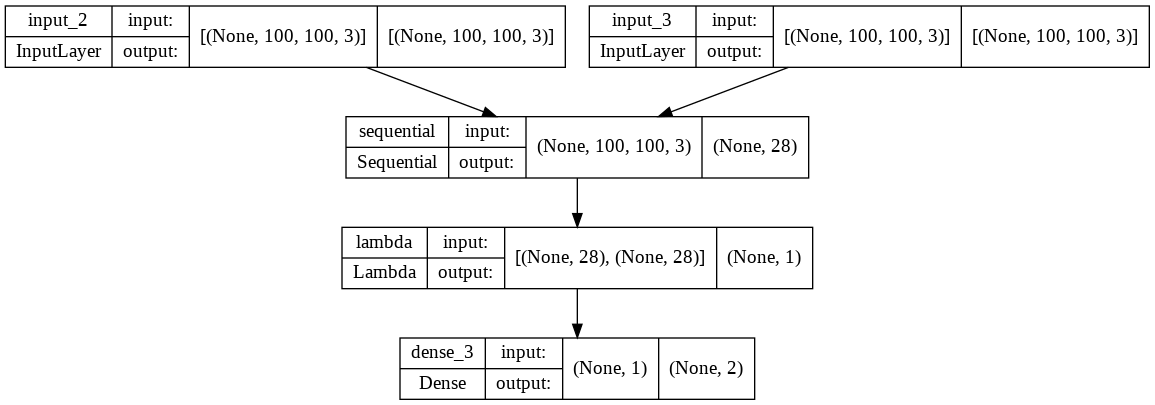

In [16]:
model = Model([img_a, img_b],prediction) #Building model
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [10]:
#Loss function
def loss(margin=1):
    import tensorflow as tf
    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [11]:
model.compile(loss=loss(margin=1), optimizer=tensorflow.keras.optimizers.Adam()
              , metrics=["accuracy"]) #Model settings
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True) #Early stopping to avoid overfitting
history=model.fit([train_images1,train_images2],train_labels,validation_split=.2,batch_size= 32, epochs=20 ,callbacks=[es]) #Model Training

Epoch 1/20
150/150 [==============================] - 20s 57ms/step - loss: 0.1581 - accuracy: 0.7385 - val_loss: 0.1243 - val_accuracy: 0.9433
Epoch 2/20
150/150 [==============================] - 6s 42ms/step - loss: 0.0996 - accuracy: 0.9904 - val_loss: 0.0850 - val_accuracy: 1.0000
Epoch 3/20
150/150 [==============================] - 6s 42ms/step - loss: 0.0696 - accuracy: 0.9998 - val_loss: 0.0606 - val_accuracy: 1.0000
Epoch 4/20
150/150 [==============================] - 6s 43ms/step - loss: 0.0506 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 1.0000
Epoch 5/20
150/150 [==============================] - 6s 43ms/step - loss: 0.0376 - accuracy: 1.0000 - val_loss: 0.0331 - val_accuracy: 1.0000
Epoch 6/20
150/150 [==============================] - 6s 43ms/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 7/20
150/150 [==============================] - 6s 43ms/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 1.000

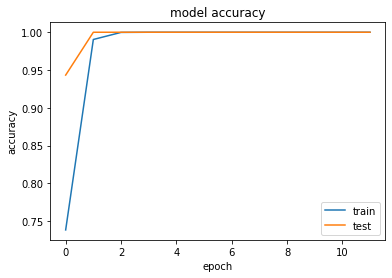

In [17]:
plt.plot(history.history['accuracy']) #Get accuracy history of trained model
plt.plot(history.history['val_accuracy']) #Get validation accuracy
plt.title('model accuracy') #Set title of graph
plt.ylabel('accuracy') #Set y label
plt.xlabel('epoch') #Set x label
plt.legend(['train', 'test'], loc='lower right') #Set legends of graph
plt.show() #Plot graph